# Deformable wall and deformable half-circle

*Produces Figure (4)*

### Affiliations & E-mails
Flavio Lorez: [florez@ethz.ch](mailto:florez@ethz.ch)

¹: Computational Mechanics of Building Materials, ETH Zurich, Switzerland. 

### Environment setup
Special dependencies to run this notebook:
- `h5py` (and the HDF5 library)
- `mpi4py`
- `bamboost`, a python library built at CMBM for data management using HDF5.

To install `bamboost`:

```bash
git clone https://gitlab.ethz.ch/compmechmat/research/libs/bamboost.git
```

```bash
cd bamboost
pip install .
```
Alternatively to using `pip`, you can append the system path to find the package.

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
from scipy.interpolate import interp1d
import seaborn as sns

from bamboost import Manager

import utilities
utilities.set_plot_theme()

import warnings
warnings.filterwarnings('ignore')

> Please specify the path to the database (The data can be found on researchcollection/eth)

In [29]:
# Enter the path to the data
database_path = '../out'

db = Manager(database_path)
db

In [3]:
# Specify domain of integration
xi = np.linspace(-1, 1, 2000)
yi = np.linspace(8, 12, 2000)

# the loop checks if it was computed already
for sim in db.sims((db.df.status=='Finished') & (db.df.tag=='def-def')):
    if 'traction' in sim.userdata.keys():
        continue
    b = sim.get_data_interpolator('disk_b', -1)
    profile = utilities.integrate_axis(b, xi, yi, 'y')
    grp = sim.userdata.require_group('traction')
    grp.add_dataset('profile', profile)
    grp.add_dataset('xi', xi)


### Select simulations from database

In [9]:
# Select the simulations
# ----------------------
sim_1 = db['eps_02_k500']
sim_2 = db['eps_05_k500']

db.df[db.df.id.isin((sim_1.uid, sim_2.uid))]

id notes    status    E  eps      k  \
14  eps_05_k500        Finished  1.0  0.5  500.0   
19  eps_02_k500        Finished  1.0  0.2  500.0   

                                                 mesh  mobility  poissons  \
14  /cluster/work/cmbm/florez/growth-phasefield/co...  0.000001       0.2   
19  /cluster/work/cmbm/florez/growth-phasefield/co...  0.000001       0.2   

                problem_type  processors    r0  residual_stiffness  submitted  \
14  cranck nicolson implicit           4  10.0               0.001      False   
19  cranck nicolson implicit           4  10.0               0.001      False   

        tag           time_stamp  
14  def-def  2023-09-22 16:48:15  
19  def-def  2023-09-22 16:49:00

### Function definitions used by plot

In [7]:
from scipy import interpolate

def y_comp_scaler(aspect_ratio: float):
    """Scale y component of forces to remain rectangular.
    
    Args:
        aspect_ratio: aspect ratio of axis
    """
    return aspect_ratio * np.tan(np.pi/2 - np.arctan(aspect_ratio**-1))

def plot_force_field(ax, sim, arrow_scale=250, arrow_width=0.01, cmap=plt.cm.Reds, b_field_name='wall_b_before', h_size = 1/10, k_scale=1):
    """Plots the force field before equilibrium."""
    
    # Get coordinates & rotate the plot by swapping the coordinate x, y columns
    coords = sim.mesh[0]
    coords = np.vstack((coords[:, 1]-10, coords[:, 0])).T
    slicer = (coords[:, 0]>-1) & (coords[:,0]<1) & (coords[:, 1]>-3) & (coords[:, 1]<3)
    coords_slice = coords[slicer]
    
    # Get the force field data
    wall_bf = interpolate.NearestNDInterpolator(coords, sim.data[b_field_name].at_step(-1))
    wall_phi, disk_phi = sim.data['wall_phi'].at_step(-1).flatten(), sim.data['disk_phi'].at_step(-1).flatten()
    wall_phi, disk_phi = wall_phi[slicer], disk_phi[slicer]

    x_range = (-.5, .5)
    y_range = (-2, 2)
    x_size, y_size = np.ediff1d(x_range)[0]*h_size, np.ediff1d(y_range)[0]*h_size
    x_axis_scale = y_size/x_size

    # Compute and plot the intersection theta
    theta = wall_phi*disk_phi - .25
    theta[theta<0] = 0.0
    theta_plot = ax.tricontourf(*coords_slice.T, theta, zorder=0, cmap=plt.cm.Purples, alpha=.7, levels=20)
    for cs in theta_plot.collections:
        cs.set_rasterized(True)
        
    # Plot 0.5 level of both bodies
    ax.tricontour(*coords_slice.T, disk_phi, levels=[.5])
    ax.tricontour(*coords_slice.T, wall_phi, levels=[.5])
    ax.set(
        xlim=x_range,
        ylim=y_range,
        xlabel='$x$',
        ylabel='$y$',
        )

    # Compute the distortion of the axes and scale the arrows accordingly
    ax_ratio = (ax.get_position().width*ax.get_figure().get_size_inches()[0])/(ax.get_position().height*ax.get_figure().get_size_inches()[1])
    scale_y_arrow = y_comp_scaler(x_axis_scale*ax_ratio)

    # Plot the arrows
    xx, yy = np.meshgrid(np.arange(*x_range, x_size), np.arange(*y_range, y_size))
    uv = wall_bf(xx, yy)*k_scale
    length = np.linalg.norm(uv, axis=2)
    ax.quiver(xx, yy, -uv[:,:,1]/np.linalg.norm(uv,axis=2)*length, -scale_y_arrow*uv[:,:,0]/np.linalg.norm(uv,axis=2)*length, length,
              pivot='tail', minlength=1e-3, width=arrow_width, scale=arrow_scale, cmap=cmap, angles='xy')

    xx, yy = np.meshgrid(np.arange(x_range[0]+x_size/2, x_range[1]+x_size/2, x_size), np.arange(y_range[0]+y_size/2, y_range[1]+y_size/2, y_size))
    uv = wall_bf(xx, yy)*k_scale
    length = np.linalg.norm(uv, axis=2)
    ax.quiver(xx, yy, -uv[:,:,1]/np.linalg.norm(uv,axis=2)*length, -scale_y_arrow*uv[:,:,0]/np.linalg.norm(uv,axis=2)*length, length,
              pivot='tail', minlength=1e-3, width=arrow_width, scale=arrow_scale, cmap=cmap, angles='xy')

    return theta_plot  # returned to plot its colorbar
    
def plot_force_field_after(ax, sim, arrow_scale=250/20, arrow_width=0.01, cmap=plt.cm.Reds, b_field_name='wall_b', plot_theta=True, h_size=1/10, k_scale=1):
    """Plots the force field after equilibrium."""

    # Get coordinates & rotate the plot by swapping the coordinate x, y columns
    coords = sim.mesh[0]
    coords = np.vstack((coords[:, 1]-10, coords[:, 0])).T
    slicer = (coords[:, 0]>-1)&(coords[:,0]<1) & (coords[:, 1]>-3) & (coords[:, 1]<3)
    coords_slice = coords[slicer]
    
    # Load the data
    wall_bf = interpolate.NearestNDInterpolator(coords, sim.data[b_field_name].at_step(-1))
    wall_phi, disk_phi = sim.data['wall_phi'].at_step(-1).flatten(), sim.data['disk_phi'].at_step(-1).flatten()
    wall_phi, disk_phi = wall_phi[slicer], disk_phi[slicer]

    x_range = (-.5, .5)
    y_range = (-2, 2)
    x_size, y_size = np.ediff1d(x_range)[0]*h_size, np.ediff1d(y_range)[0]*h_size
    x_axis_scale = y_size/x_size

    # Compute and plot the intersection theta
    theta = wall_phi*disk_phi - .25
    theta[theta<0] = 0.0
    if plot_theta:
        theta_plot = ax.tricontourf(*coords_slice.T, theta, zorder=0, cmap=plt.cm.Purples, levels=20)
        for cs in theta_plot.collections:
            cs.set_rasterized(True)
    else:
        theta_plot = None
    ax.tricontour(*coords_slice.T, disk_phi, levels=[.5])
    ax.tricontour(*coords_slice.T, wall_phi, levels=[.5])
    ax.set(
        xlim=(-.5, .5),
        ylim=(-2, 2),
        xlabel='$x$',
        ylabel='$y$',
    )

    # Compute the distortion of the axes and scale the arrows accordingly
    ax_ratio = (ax.get_position().width*ax.get_figure().get_size_inches()[0])/(ax.get_position().height*ax.get_figure().get_size_inches()[1])
    scale_y_arrow = y_comp_scaler(x_axis_scale*ax_ratio)

    # Plot the force arrows
    xx, yy = np.meshgrid(np.arange(*x_range, x_size), np.arange(*y_range, y_size))
    uv = wall_bf(xx, yy)*k_scale
    length = np.linalg.norm(uv, axis=2)
    ax.quiver(xx, yy, uv[:,:,1]/np.linalg.norm(uv,axis=2)*length, scale_y_arrow*uv[:,:,0]/np.linalg.norm(uv,axis=2)*length, length,
              pivot='tail', minlength=1e-3, width=arrow_width, scale=arrow_scale, cmap=cmap, angles='xy')

    xx, yy = np.meshgrid(np.arange(x_range[0]+x_size/2, x_range[1]+x_size/2, x_size), np.arange(y_range[0]+y_size/2, y_range[1]+y_size/2, y_size))
    uv = wall_bf(xx, yy)*k_scale
    length = np.linalg.norm(uv, axis=2)
    ax.quiver(xx, yy, uv[:,:,1]/np.linalg.norm(uv,axis=2)*length, scale_y_arrow*uv[:,:,0]/np.linalg.norm(uv,axis=2)*length, length,
              pivot='tail', minlength=1e-3, width=arrow_width, scale=arrow_scale, cmap=cmap, angles='xy')

    return theta_plot

In [32]:
import matplotlib as mpl
from scipy.interpolate import LinearNDInterpolator

def compute_principal_stress(arr):
    """Compute the principal stresses from the stress field.

    Args:
        - arr: array (N, 3)
    """
    midpoint = .5*(arr[:, 0]+arr[:, 1])
    radius = np.sqrt(((arr[:,0]-arr[:,1])/2)**2 + arr[:,2]**2)
    return np.vstack((midpoint+radius, midpoint-radius, radius)).T


def plot_bottom_row(sim, sim_2, ax, bx, cx, dx, cbax, plot_a=True, plot_b=True, plot_c=True):
    """Plots the bottom row of the figure (schematic, stress distribution, traction profile)."""

    Estar = (2*1/1)**-1  # The effective stiffness for the Hertz solution
    R = (1/10)**-1
    hertz = utilities.HertzContactJohnson(
        R, Estar, -sim.globals.traction_y.iloc[-1]
    )

    blue, red = '#68a2b3', '#d9a9a9'

    if plot_a:

        cmap = plt.cm.RdBu_r
        my_cmap=cmap(np.arange(cmap.N))
        my_cmap[:, -1] = np.linspace(0.3, 1, cmap.N)
        my_cmap = mpl.colors.ListedColormap(my_cmap)

        # Load the data
        coords = sim.mesh[0]
        wall_phi = sim.data['wall_phi'].at_step(-1).flatten()
        disk_phi = sim.data['disk_phi'].at_step(-1).flatten()
        wall_vm = sim.data['wall_vonMises'].at_step(-1).flatten()
        cyl_vm = sim.data['disk_vonMises'].at_step(-1).flatten()
        vonMises_range = (0, cyl_vm.max())

        # Plot von mises stress
        tric = ax.tricontourf(*coords[wall_phi>.5].T[::-1],
                    wall_vm[wall_phi>.5],
                    vmin=vonMises_range[0], vmax=vonMises_range[1],
                    cmap=my_cmap, levels=20)
        ax.tricontour(*coords[wall_phi>.5].T[::-1],
                    wall_vm[wall_phi>.5],
                    vmin=vonMises_range[0], vmax=vonMises_range[1],
                    cmap=my_cmap, levels=20, linewidths=.4)
        ax.tricontourf(*coords[disk_phi>.5].T[::-1],
                    cyl_vm[disk_phi>.5],
                    vmin=vonMises_range[0], vmax=vonMises_range[1],
                    cmap=my_cmap, levels=20)
        ax.tricontour(*coords[disk_phi>.5].T[::-1],
                    cyl_vm[disk_phi>.5],
                    vmin=vonMises_range[0], vmax=vonMises_range[1],
                    cmap=my_cmap, levels=20, linewidths=.4)

        # Plot 0.5 levels for both bodies
        ax.tricontour(coords.T[1], coords.T[0], wall_phi, levels=[.5], linewidths=.5)
        ax.tricontour(coords.T[1], coords.T[0], disk_phi, levels=[.5], linewidths=.5)

        ax.set_aspect('equal', 'box')
        ax.set(xlabel='$x$', ylabel='$y$',)
        ax.grid(False)
        
        # Plot von Mises colorbar
        cb = plt.colorbar(tric, cax=cbax)
        cb.set_label('$\sigma_V/E$', labelpad=-14)
        cb.set_ticks([0, vonMises_range[1]])
        cb.formatter.set_powerlimits((0,0))

# -------------------------------------------------------------------------------------
    if plot_b:

        # CYLINDER
        # Load data / get linear interpolator for phi and stress
        sig_func = sim.get_data_interpolator('disk_sig', -1)
        phi_func = sim.get_data_interpolator('disk_phi', -1)

        def tau_princ(x, y):
            princ_stresses = compute_principal_stress(sig_func(x, y))
            return princ_stresses[:, 2]
        xi = 0  # for x = 0
        yi = np.linspace(0, 20, 2000)  # for y in [0, 20]
        colors=('darkred', 'steelblue', '0.2')
        linestyles=('--', '-', '-.')

        # Plot stress components of cylinder
        bx.grid(False)
        bx.annotate('Cylinder', xy=(0.02, 0.95), xycoords=bx.transAxes, va='top')
        bx.set_prop_cycle(color=colors, linestyle=linestyles)
        bx.plot(yi, sig_func(xi, yi)[:, [0, 1]]/hertz.p0, label=('$\sigma_{yy}$', '$\sigma_{xx}$') )
        bx.plot(yi, tau_princ(xi, yi)/hertz.p0, label= r'$\tau_{max}$')
        bx.legend(framealpha=1)
        bx.set(
            xlim=(0, 20),
            ylabel='$\sigma/p_0$',
        )

        # Plot phi of cylinder
        bx_twin = bx.twinx()
        bx_twin.plot(yi, phi_func(xi, yi), c='k', alpha=.6, ls='--',
                    label='$\phi_{cyl}$', lw=.5)
        bx_twin.axvspan(0, 10, color=blue, alpha=.3, zorder=-1)
        bx_twin.set(
            yticks=[],
            # ylim=(-.1, 1.1),
            )
        bx_twin.legend(loc='lower right', framealpha=1)
        bx_twin.set_zorder(-1)
        bx.patch.set_visible(False)

        # WALL
        # Load data / get linear interpolator for phi and stress for wall
        sig_func_wall = sim.get_data_interpolator('wall_sig', -1)
        phi_func_wall = sim.get_data_interpolator('wall_phi', -1)

        # Plot stress components of the wall
        cx.grid(False)
        cx.annotate('Plane', xy=(0.02, 0.95), xycoords=cx.transAxes, va='top')
        def wall_princ(x, y):
            return compute_principal_stress(sig_func_wall(x, y))[:, 2]

        cx.set_prop_cycle(color=colors, linestyle=linestyles)
        cx.plot(yi, sig_func_wall(xi, yi)[:, [0, 1]]/hertz.p0, label=('$\sigma_{yy}$', '$\sigma_{xx}$'))
        cx.plot(yi, wall_princ(xi, yi)/hertz.p0, label=r'$\tau_{max}$')
        cx.legend(framealpha=1)
        cx.set(
            xlabel='$x$',
            ylabel='$\sigma/p_0$',
        )
        
        # Plot phi of wall
        cx_twin = cx.twinx()
        cx_twin.plot(yi, phi_func_wall(xi, yi), c='k', alpha=.6, ls='--',
                    label='$\phi_{plane}$', lw=.5)
        cx_twin.axvspan(10, 20, color=red, alpha=.3, zorder=-1)
        cx_twin.set(yticks=[])
        cx_twin.legend(loc='lower right', framealpha=1)
        cx_twin.set_zorder(-1)
        cx.patch.set_visible(False)
            
# -------------------------------------------------------------------------------------
    if plot_c:
        
        colors = sns.color_palette('Reds', n_colors=4)

        # Load data from simulations
        xi = sim.userdata['traction/xi'][:]
        traction_1 = sim.userdata['traction/profile'][:, 1]
        traction_2 = sim_2.userdata['traction/profile'][:, 1]

        # Plot the traction profiles
        dx.plot(xi/hertz.area, np.abs(traction_2)/hertz.p0, c=colors[1], label=r'$\epsilon=0.5$', lw=1)
        dx.plot(xi/hertz.area, np.abs(traction_1)/hertz.p0, c=colors[3], label=r'$\epsilon=0.2$', lw=1)
        dx.plot(xi/hertz.area, hertz.contact_pressure(xi), c='k', alpha=.6, ls='--', label='Hertz solution')
        dx.set(
            xlim=(-1/hertz.area, 1/hertz.area),
            ylim=(0, 1.2),
            xlabel='$r/a_0$', ylabel='$p/p_0$',
        )
        dx.grid(False)
        
        # Split the legend into two
        lines, labels = dx.get_legend_handles_labels()
        legend1 = dx.legend(lines[:-1], labels[:-1], loc='upper right')
        legend2 = dx.legend([lines[-1]], [labels[-1]], loc='upper left')
        dx.add_artist(legend1)
        dx.add_artist(legend2)

### Figure

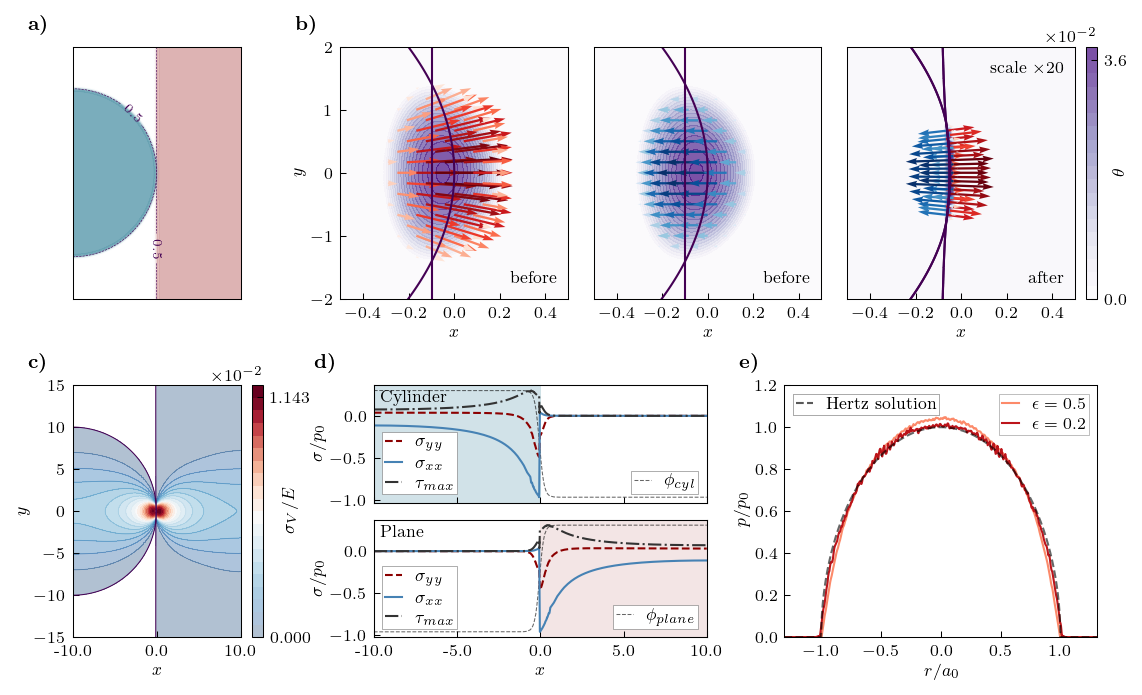

In [33]:
import matplotlib as mpl

utilities.set_plot_theme()
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['text.usetex'] = True

# ------------------------------------------------------------------------------
# Figure setup
# ------------------------------------------------------------------------------
fig = plt.figure(figsize=(7.4, 4.8), )
w, h = fig.get_size_inches()
axes = [0]*4

left = .05
bottom = .15/2
height = .7/2
w_arrow_plot = .205
w_pad = .07
w_pad_nolabel = w_pad/3
h_pad = .12
h_pad_nolabel = h_pad/5

# Top row of subplots
axes[0] = fig.add_axes((left, bottom+height+h_pad, height*2/3*h/w, height))
axes[0].set(xticks=[], yticks=[])
axes[1] = fig.add_axes((axes[0].get_position().x1+w_pad+0.02, bottom+height+h_pad, w_arrow_plot, height))
axes[2] = fig.add_axes((axes[1].get_position().x1+w_pad_nolabel, bottom+height+h_pad, w_arrow_plot, height))
axes[3] = fig.add_axes((axes[2].get_position().x1+w_pad_nolabel, bottom+height+h_pad, w_arrow_plot, height))
cbax = fig.add_axes((axes[3].get_position().x1+.01, bottom+height+h_pad, .01, height))
[ax.grid(False) for ax in axes if isinstance(ax, plt.Axes)]

# Second row of plots
bxes = [0]*4
bxes[0] = fig.add_axes((left, bottom, height*2/3*h/w, height))
cbax_2 = fig.add_axes((bxes[0].get_position().x1+.01, bottom, .01, height))
bxes[1] = fig.add_axes((cbax_2.get_position().x1+.03+w_pad, bottom, .3, height/2-h_pad_nolabel/2))
bxes[2] = fig.add_axes((bxes[1].get_position().x0, bxes[1].get_position().y1+h_pad_nolabel, bxes[1].get_position().width, height/2-h_pad_nolabel/2), sharex=bxes[1])
bxes[3] = fig.add_axes((bxes[1].get_position().x1+w_pad, bottom, cbax.get_position().x1-bxes[1].get_position().x1-w_pad, height))

# ------------------------------------------------------------------------------

# Top row figures

arrow_width = 0.01
arrow_scale = 150

# SCHEMATIC (a)

blue, red = '#68a2b3ff', '#d9a9a9ff'
def cmap_uni(color, color_negative='#ffffff00'):
    color_negative = list(color); color_negative[-2:] = ['0','0']; color_negative = "".join(color_negative)
    c = [color_negative, color]
    v = [0, 1]
    return mpl.colors.LinearSegmentedColormap.from_list('Uni', list(zip(v,c)), N=256)

sub_index = 0

# Load the data
coords = sim_1.mesh[0][:, ::-1]
disk_phi = sim_1.data['disk_phi'].at_step(0).flatten()
wall_phi = sim_1.data['wall_phi'].at_step(0).flatten()

# Plot the phase field of the wall
tri = axes[sub_index].tricontour(*coords.T, wall_phi, cmap=cmap_uni(red), levels=np.linspace(0, 1.0001, 10),
                                 vmin=.1, vmax=.9, linewidths=.3)
for col in tri.collections: col.set_rasterized(True)
tri = axes[sub_index].tricontourf(*coords.T, wall_phi,
                                  cmap=cmap_uni(red), levels=np.linspace(.5, 1.001, 5))
CS = axes[sub_index].tricontour(*coords.T, wall_phi, levels=[.5], linestyles='--', linewidths=.3)
plt.clabel(CS, inline=1, fontsize=6, manual=[(7.5, -9)])

# Plot the phase field of the disk
tri = axes[sub_index].tricontour(*coords.T, disk_phi, cmap=cmap_uni(blue), levels=np.linspace(0, 1.0001, 10),
                                 vmin=.1, vmax=.9, linewidths=.3)
tri = axes[sub_index].tricontourf(*coords.T, disk_phi, cmap=cmap_uni(blue), levels=np.linspace(.5, 1.001, 5))
for col in tri.collections: col.set_rasterized(True)
CS = axes[sub_index].tricontour(*coords.T, disk_phi, levels=[.5], linestyles='--', linewidths=.3)
plt.clabel(CS, inline=1, fontsize=6, manual=[(8, 8)])

# FORCES BEFORE (b, c)

# Select simulation for the body forces before equilibrium
sim_bf = db['body_force_before']

# Plot force field for wall & cylinder
plot_force_field(axes[1], sim_bf, b_field_name='wall_b_before', arrow_scale=arrow_scale, h_size=1/12, k_scale=1)
theta_plot = plot_force_field(axes[2], sim_bf, b_field_name='disk_b_before', cmap=plt.cm.Blues, h_size=1/12, k_scale=1)

# FORCES AFTER (d)

plot_force_field_after(axes[3], sim_1, arrow_scale=arrow_scale/20, b_field_name='wall_b', cmap=plt.cm.Reds, h_size=1/30, k_scale=2)
plot_force_field_after(axes[3], sim_1, arrow_scale=arrow_scale/20, b_field_name='disk_b', cmap=plt.cm.Blues, h_size=1/30, k_scale=2)

cb = plt.colorbar(theta_plot, cax=cbax)
cb.set_label(r'$\theta$', labelpad=-7)
cb.set_ticks([0, 3.6e-2])
cb.formatter.set_powerlimits((0,0))

# Some figure tweaks
axes[1].xaxis.set_major_locator(mpl.ticker.MultipleLocator(.2))
axes[2].xaxis.set_major_locator(mpl.ticker.MultipleLocator(.2))
axes[3].xaxis.set_major_locator(mpl.ticker.MultipleLocator(.2))
axes[3].annotate(r'scale $\times 20$', xy=(.95, .95), xycoords=axes[3].transAxes, ha='right', va='top')
axes[1].annotate(r'before', xy=(.95, .05), xycoords=axes[1].transAxes, ha='right', va='bottom')
axes[2].annotate(r'before', xy=(.95, .05), xycoords=axes[2].transAxes, ha='right', va='bottom')
axes[3].annotate(r'after', xy=(.95, .05), xycoords=axes[3].transAxes, ha='right', va='bottom')
[ax.set(ylabel='$y$', xlabel='$x$') for ax in axes]
axes[2].set(ylabel='', yticks=[])
axes[3].set(ylabel='', yticks=[])
axes[0].set(ylabel='', xlabel='')

# -----------------------------------------------------------------------------

# Bottom row figures

plot_bottom_row(sim_1, sim_2, bxes[0], bxes[2], bxes[1], bxes[3], cbax=cbax_2, plot_a=True, plot_b=True)

# Some figure tweaks
bxes[2].set(xlabel='')
plt.setp(bxes[2].get_xticklabels(), visible=False)
bxes[0].xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: x-10))
bxes[1].xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: x-10))


# -----------------------------------------------------------------------------

# Subplot labels
utilities.subplot_label(axes[0], 'a')
utilities.subplot_label(axes[1], 'b')
utilities.subplot_label(bxes[0], 'c')
utilities.subplot_label(bxes[2], 'd', -0.4)
utilities.subplot_label(bxes[3], 'e')

fig.savefig('figs/figure_hertz_deformable_full.pdf', dpi=500, pad_inches=0)